Importing the stuff we need

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import nltk

2023-11-28 11:18:31.365839: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 11:18:31.365877: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 11:18:31.365901: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 11:18:31.374337: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /home/sgzmd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Defining some constants

In [3]:
# Constants
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MAX_TOKENS = 128

Let's read and pre-process the data

In [5]:
df = pd.read_csv("../full.csv")  # Load the CSV file into a pandas DataFrame

# drop all non-string records, unclear where they are coming from
df = df[df.apply(lambda row: isinstance(row['Body'], str) and isinstance(row['Genres'], str), axis=1)]

def is_sf_genre(genre: str) -> bool:
    return genre.startswith('sf') or genre == 'popadanec' or genre == 'litrpg'

# define is_sf label
df['is_sf'] = df['Genres'].apply(lambda genres: any(is_sf_genre(genre) for genre in genres.split(';')))
df.head()

,ID,Genres,Authors,BookTitle,Body,Annotation,FileName,IsSelected,is_sf
0,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,sf_fantasy_city;det_action;popadanec;magician_...,Извращенный отшельник;Илья Романов,Наемник «S» ранга,sf_fantasy_city\n det_action\n popadanec\n...,"\n Прожив пять веков в шкуре вампира, я оты...",729588.fb2,0,True
1,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,fanfiction;magician_book;popadanec;network_lit...,Cyberdawn,Лишний свиток,fanfiction\n magician_book\n popadanec\n ...,"\n Попаданец в черножопого, ехидного, своло...",729587.fb2,0,True
2,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,religion_orthodoxy;religion_christianity;relig...,Коллектив авторов,Святитель Василий Великий,religion_orthodoxy\n religion_christianity\n...,NaN,729595.fb2,0,False
3,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,sf_heroic;sf_humor;sf_social,Андрей Немиров,Квестер,sf_heroic\n sf_humor\n sf_social\n \n ...,"\n Доброго времени суток, читатель! По слов...",729601.fb2,0,True
4,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,sf_horror;literature_19;literature_20;sf_horro...,Джеймс Брандер Мэтьюз;Артур Грей;Эдмунд Митчел...,Мистические истории. Фантом озера,sf_horrorliterature_19literature_20sf_horrorfo...,NaN,729599.fb2,0,True


Let's define synthetic column that we'll be doing the actual classification on

In [8]:
# remove all rows which do not have annotation
df = df[df['Annotation'].str.len() >= 20]

# Create 'body' field by concatenating 'Annotation', 'Authors', 'Genres', and 'BookTitle'
df['body'] = df['Annotation'] + ' ' + df['Authors'] + ' ' + df['Genres'] + ' ' + df['BookTitle']
df.sample(10)

,ID,Genres,Authors,BookTitle,Body,Annotation,FileName,IsSelected,is_sf,body
22775,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_fantasy,Александр Золотько,Слепцы,sf_fantasy АлександрЗолотько215eac1c-2a81-102a...,Мир устроен просто: есть Ватага и есть все ост...,225125.fb2,0,True,Мир устроен просто: есть Ватага и есть все ост...
130847,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_fantasy,Кристофер Банч,Крылья урагана,sf_fantasy\n \n Кристофер\n ...,"\n У Хэла Кэйлиса, родившегося и выросш...",580914.fb2,0,True,"\n У Хэла Кэйлиса, родившегося и выросш..."
80513,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,litrpg;sf_fantasy,Алексей Свадковский,Игра Хаоса,litrpg\n sf_fantasy\n \n Алексей\n Р...,"\n \n По воле Смеющегося господина, одно...",438593.fb2,0,True,"\n \n По воле Смеющегося господина, одно..."
83097,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,child_tale;children,Евгений Федоров,Вшивая Горка,child_talechildren ЕвгенийСергеевичФедоровebf5...,В новой сказке Совёнок Знакомится с историей В...,447711.fb2,0,False,В новой сказке Совёнок Знакомится с историей В...
67518,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,prose_su_classics,Валерий Рогов,Нулевая долгота,prose_su_classics\n \n Валерий\n Степа...,\n Книга повестей Валерия Рогова отображает...,393859.fb2,0,False,\n Книга повестей Валерия Рогова отображает...
167667,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,love_sf,Валентина Никитина,Поймать судьбу за хвост,love_sfВалентинаПетровнаНикитинаde6bd94f-2114-...,"Каждому интересно знать, какую судьбу уготовил...",673050.fb2,0,False,"Каждому интересно знать, какую судьбу уготовил..."
64465,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_space,Renash,UZ-Worga,sf_space\n \n \n Renash\n \n UZ-Wo...,\n Текст с форума forum.eve-ru.com\n,383525.fb2,0,True,\n Текст с форума forum.eve-ru.com\n Re...
150716,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_cyberpunk,Ника Крылатая,Его строптивое Солнце,sf_cyberpunk\n \n Ника \n Крылатая \n ...,\n Можно ли спрятаться от чудовища в ночном...,631145.fb2,0,True,\n Можно ли спрятаться от чудовища в ночном...
242616,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_horror,Игорь Лесев,23,sf_horror ИгорьВасильевичЛесев99ab0072-e38a-10...,Если вы хотите почитать настоящий русский ужас...,163867.fb2,0,True,Если вы хотите почитать настоящий русский ужас...
91735,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_action,Мария Круз;Андрей Круз,Ар-Деко,sf_action\n \n Мария\n Круз...,"\n То, что мы задумали на этот раз, без...",471638.fb2,0,True,"\n То, что мы задумали на этот раз, без..."


In [9]:
# Filter the dataframe based on the conditions
df_selected_1 = df[(df['IsSelected'] == 1)]
df_selected_0 = df[(df['IsSelected'] == 0) & (~df['is_sf'])]

# -1 are manually selected negative samples
df_selected_neg = df[(df['IsSelected'] == -1)]

# Sample the same number of records where selected = 0
df_selected_0_sampled = df_selected_0.sample(n=len(df_selected_1), random_state=42)

negative_samples = pd.concat([df_selected_0_sampled, df_selected_neg])

# Set 'selected' to 0 for all negative_samples
negative_samples['IsSelected'] = 0

# Concatenate the two dataframes
new_df = pd.concat([df_selected_1, negative_samples])

# Reset the index of the new dataframe
new_df.reset_index(drop=True, inplace=True)

# Print the new dataframe
new_df.sample(10)


,ID,Genres,Authors,BookTitle,Body,Annotation,FileName,IsSelected,is_sf,body
414,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_action;sf_space;sf_cyberpunk,Михаил Атаманов,Искажающие Реальность-8,sf_action\n sf_space\n sf_cyberpunk\n \n...,\n Вторжение агрессоров из другой галактики...,621229.fb2,1,True,\n Вторжение агрессоров из другой галактики...
771,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,adventure;love_fantasy;love_sf,Татьяна Гранд,Кто ты?,adventurelove_fantasylove_sfТатьянаГрандaaf7c4...,"Алиса обыкновенная девушка, но как только она ...",686243.fb2,0,False,"Алиса обыкновенная девушка, но как только она ..."
43,/pool1/share/Downloads/Flibusta-Patch/f.fb2-74...,popadanec;sf_fantasy_city;network_literature,Василий Криптонов;Мила Бачурова,Тень врага,popadanec\n sf_fantasy_city\n network_lite...,"\n Изначальная магия — слова, заставляющие ...",746409.fb2,1,True,"\n Изначальная магия — слова, заставляющие ..."
501,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_fantasy,Андрей Рымин,Игрок,sf_fantasy\n \n Андрей\n Рымин\n \n ...,\n История попаданца-Санька в мире гигантск...,654350.fb2,1,True,\n История попаданца-Санька в мире гигантск...
1419,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,love_sf;network_literature;sf_action;sf_social,Сергей Кусков,После навсегда (весь текст),﻿\n\n \n \n love_sf\n network_li...,\n \n Это не конец. Ред. от 02...,594894.fb2,0,True,\n \n Это не конец. Ред. от 02...
1006,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,ref_ref,Юрий Апальков,Боевые корабли японского флота 10.1918-8.1945 ...,ref_ref\n \n Юрий\n Валентинович\n ...,\n Предлагаемый вниманию читателей справочн...,416008.fb2,0,False,\n Предлагаемый вниманию читателей справочн...
23,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,popadanec;sf_social;sf_history,Роман Злотников,Каждому по делам его,popadanecsf_socialsf_history РоманВалерьевичЗл...,"«Всё, изложенное в этой книге – есть полная и ...",734195.fb2,1,True,"«Всё, изложенное в этой книге – есть полная и ..."
825,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,prose_su_classics,Анатолий Никульков,Трудное знакомство,prose_su_classics\n \n Анатолий\n Васи...,\n От составителя\n …Стремление представ...,269351.fb2,0,False,\n От составителя\n …Стремление представ...
928,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,love_sf;adventure;magician_book,Дмитрий Романов,Душа Леса,love_sfadventuremagician_bookДмитрийСергеевичР...,"Обычная девочка, гуляя со своей подругой, нахо...",715350.fb2,0,False,"Обычная девочка, гуляя со своей подругой, нахо..."
416,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_heroic;sf_history;sf_fantasy;network_litera...,Рост Толбери,Кальдур Живой Доспех,sf_heroic\n sf_history\n sf_fantasy\n ne...,"\n Здесь нет тиктока, инсты и прочих атрибу...",621758.fb2,1,True,"\n Здесь нет тиктока, инсты и прочих атрибу..."


Defining tokenizer and some helper methods

In [11]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Function to segment and tokenize text
def segment_and_tokenize(text):
    # Split text into sentences
    sentences = sent_tokenize(text, language='russian')
    tokenized_output = []
    attention_mask_output = []

    for sentence in sentences:
        # Tokenize each sentence
        tokens = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_TOKENS, 
                                       truncation=True, padding='max_length', return_tensors='tf')
        tokenized_output.append(tokens['input_ids'])
        attention_mask_output.append(tokens['attention_mask'])

        # Check if we've reached the maximum number of tokens
        if sum([len(t[0]) for t in tokenized_output]) >= MAX_TOKENS:
            break

    # Combine tokenized sentences up to the maximum length
    input_ids = tf.concat(tokenized_output, axis=1)[0,:MAX_TOKENS]
    attention_mask = tf.concat(attention_mask_output, axis=1)[0,:MAX_TOKENS]

    return input_ids, attention_mask

Let's run the tokenization and segmentation of the data

In [12]:
# Apply the function to the dataset
new_df['segmented_data'] = new_df['body'].apply(segment_and_tokenize)
new_df[['tokens', 'attention_mask']] = pd.DataFrame(new_df['segmented_data'].tolist(), index=new_df.index)

2023-11-28 11:25:55.321580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 11:25:55.327734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 11:25:55.327767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 11:25:55.329354: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-28 11:25:55.329381: I tensorflow/compile

Now let's prepare and split the dataset

In [13]:
# Prepare dataset
X_ids = np.array(new_df['tokens'].tolist())
X_mask = np.array(new_df['attention_mask'].tolist())

y = new_df['is_sf'].values
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(X_ids, X_mask, y, test_size=0.2)


Let's load the model now and define how we are fine-tuning it

In [14]:
bert = TFAutoModel.from_pretrained(MODEL_NAME, from_pt=True)
input_ids = Input(shape=(MAX_TOKENS,), dtype=tf.int32, name='input_ids')
input_mask = Input(shape=(MAX_TOKENS,), dtype=tf.int32, name='attention_mask')

embeddings = bert(input_ids, attention_mask=input_mask)[0]
pooled = GlobalMaxPool1D()(embeddings)
output = Dense(1, activation='sigmoid')(pooled)

model = Model(inputs=[input_ids, input_mask], outputs=output)

2023-11-28 11:26:05.351920: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a 

In [15]:
model.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:

history = model.fit([X_train_ids, X_train_mask], y_train, batch_size=16, epochs=8, validation_split=0.2)

Epoch 1/8


2023-11-28 11:26:29.216678: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f323c245530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-28 11:26:29.216708: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2023-11-28 11:26:29.221023: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-28 11:26:29.327601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-28 11:26:29.366656: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


58/58 [==============================] - 90s 1s/step - loss: 0.4934 - accuracy: 0.7489 - val_loss: 0.3695 - val_accuracy: 0.8405
Epoch 2/8
58/58 [==============================] - 72s 1s/step - loss: 0.2323 - accuracy: 0.8929 - val_loss: 0.3274 - val_accuracy: 0.8664
Epoch 3/8
58/58 [==============================] - 99s 2s/step - loss: 0.0772 - accuracy: 0.9773 - val_loss: 0.4531 - val_accuracy: 0.8621
Epoch 4/8
58/58 [==============================] - 126s 2s/step - loss: 0.0559 - accuracy: 0.9838 - val_loss: 0.4000 - val_accuracy: 0.8750
Epoch 5/8
58/58 [==============================] - 120s 2s/step - loss: 0.0434 - accuracy: 0.9881 - val_loss: 0.4157 - val_accuracy: 0.8664
Epoch 6/8
58/58 [==============================] - 121s 2s/step - loss: 0.0180 - accuracy: 0.9935 - val_loss: 0.5577 - val_accuracy: 0.8664
Epoch 7/8
58/58 [==============================] - 87s 1s/step - loss: 0.0204 - accuracy: 0.9946 - val_loss: 0.5345 - val_accuracy: 0.8534
Epoch 8/8
58/58 [=================

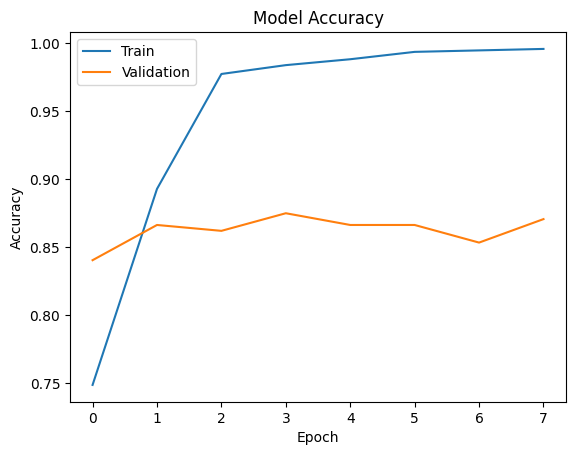

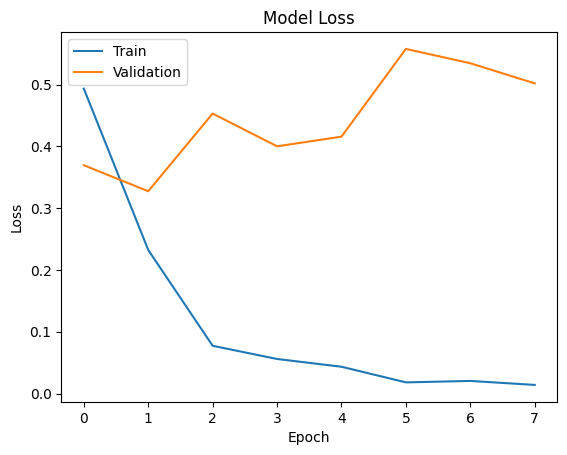

In [17]:
import matplotlib.pyplot as plt

# 'history' is the object returned by the model.fit() method in TensorFlow

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
model.evaluate([X_test_ids, X_test_mask], y_test)

4/4 [==============================] - 1s 153ms/step - loss: 0.8835 - accuracy: 0.8095


[0.8835418820381165, 0.8095238208770752]

In [18]:
model.save('mode-annotation-genre-author-title.keras')

/home/sgzmd/code/FliNet/toy/venv/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [20]:
df_sf = df[(df['IsSelected'] == 0) & df['is_sf']]
df_sf = df_sf.dropna(subset=['body'])

df_sf['segmented_data'] = df_sf['body'].apply(segment_and_tokenize)
df_sf[['tokens', 'attention_mask']] = pd.DataFrame(df_sf['segmented_data'].tolist(), index=df_sf.index)

inference_X_ids = np.array(df_sf['tokens'].tolist())
inference_X_mask = np.array(df_sf['attention_mask'].tolist())


# Make predictions
predictions = model.predict([inference_X_ids, inference_X_mask])

# Get the top 100 results
top_1000_results = df_sf.iloc[predictions.argsort(axis=0)[-1000:].flatten()]


3588/3588 [==============================] - 1768s 492ms/step


In [16]:
# top_1000_results.to_csv('top_100_results.csv', index=False)

In [33]:
top_1000_results['FileName'].to_csv('top_1000_small_matched.txt', index=False, header=False)
SQL = """
DROP TABLE IF EXISTS DetectedBooks;

CREATE TABLE DetectedBooks (
    FileName VARCHAR(255) NOT NULL,
    Annotation VARCHAR(255) NOT NULL,
    BookTitle VARCHAR(255) NOT NULL,
    Authors VARCHAR(255) NOT NULL,
    Genres VARCHAR(255) NOT NULL
);

INSERT INTO DetectedBooks (FileName, Annotation, BookTitle, Authors, Genres) VALUES
"""

for i, row in top_1000_results.iterrows():
    SQL += f"('{row['FileName']}', '{row['Annotation']}', '{row['BookTitle']}', '{row['Authors']}', '{row['Genres']}'),\n"

SQL = SQL[:-2] + ';'


In [36]:
import mysql.connector

# Connect to MySQL
cnx = mysql.connector.connect(
  host="bi2",
  port=3336,
  user="root",
  database="flibusta-analysis",
  password="toor"
)

cnx.cmd_query(SQL);

Text(value='', description='Host:', placeholder='Enter database host')

IntText(value=0, description='Port:')

Text(value='', description='Username:', placeholder='Enter username')

Password(description='Password:', placeholder='Enter password')

Text(value='', description='Database:', placeholder='Enter database name')

In [24]:
file_names = top_1000_results['FileName'].tolist()
file_names = [file_name[:-4] for file_name in file_names]
insert_values = ', '.join(["(" + fn + ")" for fn in file_names])
print(insert_values)

(601049), (611107), (566881), (506405), (698525), (613382), (679800), (494539), (745695), (722428), (345228), (400933), (614103), (751550), (34035), (427919), (361221), (613816), (452496), (174342), (353911), (367403), (649050), (160918), (187372), (685323), (652860), (532821), (184237), (257492), (593495), (729900), (184238), (666925), (536372), (142806), (276836), (669372), (535796), (645235), (729900), (539073), (585294), (510343), (723149), (568697), (627072), (721644), (357560), (733572), (753370), (740301), (432155), (225982), (707021), (457746), (733120), (620821), (727997), (365883), (365885), (365884), (365886), (716834), (495932), (740609), (620711), (609966), (495921), (658843), (289960), (158017), (715915), (289277), (733120), (220586), (625359), (733572), (370258), (144244), (604741), (370259), (93681), (458005), (189709), (644747), (67643), (638847), (596755), (391040), (464787), (407804), (474569), (669878), (594025), (640387), (361294), (403533), (289249), (594830), (59